## abstracts

In [1]:
from abc import ABC, abstractmethod
import pandas as pd
from typing import List, Dict
import time


class IndicatorLogic(ABC):
    """
    Interface for indicator calculations
    """

    @staticmethod
    @abstractmethod
    def logic(
            meta_data: dict
            , data: dict
            , timeframe: str):
        """
        Main method for producing indicator raw results
        :param timeframe: timeframe of indicator
        :type timeframe: str

        :param meta_data: any data not related to price data and needed for calculations.
        :type meta_data: dict

        :param data: price or indicator data
        :type data: dict

        :return: a dict of raw indicator results.
        """
        pass

    @staticmethod
    def _get_time(timeframe: str):
        """
        Rounds time to timeframe
        :param timeframe: timeframe of indicator
        :type timeframe: str
        :return:
        """
        current_time = time.time()
        rounded_time = int(current_time)

        if timeframe == "1m":
            rounded_time -= int(current_time) % 60
        elif timeframe == "5m":
            rounded_time -= int(current_time) % 300
        elif timeframe == "15m":
            rounded_time -= int(current_time) % 900
        elif timeframe == "30m":
            rounded_time -= int(current_time) % 1800
        elif timeframe == "1h":
            rounded_time -= int(current_time) % 3600
        elif timeframe == "4h":
            rounded_time -= int(current_time) % 14400
        elif timeframe == "1d":
            rounded_time -= int(current_time) % 86400
        elif timeframe == "1w":
            rounded_time -= int(current_time) % 604800
        elif timeframe == "1M":
            rounded_time -= int(current_time) % 2628000

        return rounded_time

    @staticmethod
    @abstractmethod
    def visualize(meta_data: dict, data: dict):
        """
        Visualization pipeline for indicator
        :param meta_data: any data not related to price data and needed for calculations.
        :type meta_data: dict
        :param data: price or indicator data
        :type data: dict
        """
        pass


# class visconfig
class VisConfig:

    # fonts
    label_fontsize = 22
    text_fontsize = 30

    # subplot
    grid_alpha = 0.25
    grid_color = (1, 1, 1)
    background_color = (0.071, 0.087, 0.131)
    default_line_color = (1, 1, 1)
    default_plot_color = (0.44, 0.33, 0.53)

    # plot
    main_size = 15
    secondary_size = 5
    width = 80
    dpi = 80

    # dimensions
    default_line_width = 2
    default_plot_width = 4

    # others
    default_line_marker = 'o'

    # candles
    default_wick_size = 0.05
    default_body_size = 0.3
    default_up_color = 'green'
    default_down_color = 'red'

    # labels
    default_label_color = 'white'
    default_label_text_color = 'black'
    
# class Plotter
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as patches
# from vis_config import VisConfig
import io

warnings.filterwarnings("ignore")


class Plotter:
    """
    Visualization tools to test indicators results
    """

    def __init__(self, secondaries_num: int = 0, secondaries_titles: list = None):
        """
        :param secondaries_num: number of secondary plots
        :type secondaries_num: int

        :param secondaries_titles: title of secondary plots
        :type secondaries_titles: list

        """
        plt.style.use('dark_background')
        size = (VisConfig.width, VisConfig.main_size + VisConfig.secondary_size * secondaries_num)
        ratios = [VisConfig.main_size] + [VisConfig.secondary_size] * secondaries_num
        fig, ax = plt.subplots(1 + secondaries_num, 1, figsize=size, dpi=VisConfig.dpi)
        self.fig = fig
        if secondaries_num == 0:
            self.main = ax
            self.secondaries = []
        else:
            self.main = ax[0]
            self.secondaries = ax[1:]

        self._set_theme(secondaries_titles)
        self._set_grid()
        self._set_margin()

    def _set_theme(self, secondaries_titles: list):
        """
        Sets the color and theme of the plot

        :param secondaries_titles: titles of secondary plots
        :type secondaries_titles: list
        """
        background_color = VisConfig.background_color
        for i, a in enumerate(self.secondaries):
            a.set_title(secondaries_titles[i], fontsize=VisConfig.text_fontsize)
            a.set_facecolor(background_color)
            a.tick_params(axis='both', which="major", labelsize=VisConfig.label_fontsize)
        self.main.set_title("Price", fontsize=VisConfig.text_fontsize)
        self.main.set_facecolor(background_color)
        self.main.tick_params(axis='both', which="major", labelsize=VisConfig.label_fontsize)
        self.fig.set_facecolor(background_color)

    def _set_grid(self):
        """
        Sets grid for main plot
        """
        plt.rcParams['grid.color'] = VisConfig.grid_color
        self.main.grid(alpha=VisConfig.grid_alpha)

    def _set_margin(self):
        """
        Sets margin of plot
        """
        self.fig.tight_layout()

    def _get_plot(self, subplot: str):
        """
        Gets a plot by string input of subplot name or index

        :param subplot: name of index of subplot
        :type subplot: str

        :return: specified plot
        """
        if subplot == "main":
            ax = self.main
        else:
            ax = self.secondaries[int(subplot)]
        return ax

    def plot_candlestick(self, data: pd.DataFrame(), candle_body_width: float = VisConfig.default_body_size
                         , candle_wick_width: float = VisConfig.default_wick_size, color_up=VisConfig.default_up_color
                         , color_down=VisConfig.default_down_color):
        """
        Plots candle sticks

        :param data: pandas dataframe of price data
        :type data: Dataframe

        :param candle_body_width: width of the body of the candle
        :type candle_body_width: float

        :param candle_wick_width: width of the wick of the candle
        :type candle_wick_width: float

        :param color_up: color of positive candles
        :type color_up: str

        :param color_down: color of negative candles
        :type color_down: str

        """
        up = data[data["close"] >= data["open"]]
        down = data[data["close"] < data["open"]]

        print(len(up))
        print(len(down))

        self.main.bar(up.index, up["close"] - up["open"], candle_body_width, bottom=up["open"], color=color_up)
        self.main.bar(up.index, up["high"] - up["close"], candle_wick_width, bottom=up["close"], color=color_up)
        self.main.bar(up.index, up["low"] - up["open"], candle_wick_width, bottom=up["open"], color=color_up)

        self.main.bar(down.index, down["close"] - down["open"], candle_body_width, bottom=down["open"],
                      color=color_down)
        self.main.bar(down.index, down["high"] - down["open"], candle_wick_width, bottom=down["open"], color=color_down)
        self.main.bar(down.index, down["low"] - down["close"], candle_wick_width, bottom=down["close"],
                      color=color_down)

    def draw_line(self, x1: float, x2: float, y1: float, y2: float, subplot: str = "main",
                  color=VisConfig.default_line_color
                  , width: float = VisConfig.default_line_width, marker: str = VisConfig.default_line_marker):
        """
        Draws a line on a plot given two point coordinates.

        :param x1: x of first point
        :type x1: float

        :param x2: x of second point
        :type x2: float

        :param y1: y of first point
        :type y1: float

        :param y2: y of second point
        :type y2: float

        :param subplot: name of index of subplot
        :type subplot: str

        :param color: color of the line
        :type color: str

        :param width: width of the line
        :type width: float

        :param marker: marker marking points of the line
        :type marker: str

        """
        ax = self._get_plot(subplot)
        ax.plot([x1, x2], [y1, y2], marker=marker, color=color, linewidth=width)

    def draw_hline(self, y: float, subplot: str = "main", color=VisConfig.default_line_color,
                   width: float = VisConfig.default_line_width):
        """
        Draws a horizontal line across plot.

        :param y: y of the line
        :type y: float

        :param subplot: name or index of subplot
        :type subplot: str

        :param color: color of line
        :type color: str

        :param width: width of the line
        :type width: float

        """
        ax = self._get_plot(subplot)
        xmin, xmax = ax.get_xlim()
        ax.hlines(y, color=color, linewidth=width, xmin=xmin, xmax=xmax)

    def draw_vline(self, x: float, subplot: str = "main", color=VisConfig.default_line_color,
                   width: float = VisConfig.default_line_width):
        """
        Draws a vertical line across plot.

        :param x: x of the line
        :type x: float

        :param subplot: name or index of subplot
        :type subplot: str

        :param color: color of line
        :type color: str

        :param width: width of the line
        :type width: float

        """
        ax = self._get_plot(subplot)
        ymin, ymax = ax.get_ylim()
        ax.vlines(x, color=color, linewidth=width, ymin=ymin, ymax=ymax)

    def plot(self, data: pd.Series, subplot: str = "main", color=VisConfig.default_plot_color
             , width=VisConfig.default_plot_width, marker=VisConfig.default_line_marker):
        """
        Plots a data line on the specified.

        :param data: data of the plot
        :type data: Series

        :param subplot: name or index of subplot
        :type subplot: str

        :param color: color of data line
        :type color: str

        :param width: width of data line
        :type width: float

        :param marker: marker of data line
        :type marker: str
        """
        ax = self._get_plot(subplot)
        ax.plot(data, color=color, linewidth=width, marker=marker)

    def draw_label(self, text: str, width: float, height: float, x: float, y: float, subplot: str = "main"
                   , background_color=VisConfig.default_label_color
                   , text_color=VisConfig.default_label_text_color):
        """
        Draws a rectangle label on specified subplot
        :param text: text of label
        :type text: str

        :param width: width of label
        :type width: float

        :param height: height of label
        :type height: float

        :param x: x position of label
        :type x: float

        :param y: y position of label
        :type y: float

        :param subplot: name or index of subplot
        :type subplot: str

        :param background_color: color of label background
        :type background_color: str

        :param text_color: color of label text
        """
        ax = self._get_plot(subplot)
        # noinspection PyTypeChecker
        # since rectangle position is lower left, we reduce these values to make position center of label
        rect = patches.FancyBboxPatch((x - width / 2, y - height / 2), width, height, facecolor=background_color)
        ax.add_patch(rect)
        ax.annotate(text, (x, y), color=text_color, fontsize=VisConfig.text_fontsize, va='center', ha='center')

    def fill(self, line_1: pd.Series, line_2: pd.Series, subplot="main", fill_color='green', fill_alpha=0.3):
        """
        Fills area between the two lines
        :param line_1: the higher line
        :type line_1: Series:

        :param line_2: the lower line
        :type line_2: Series:

        :param subplot: name or index of subplot
        :type subplot: str

        :param fill_color: color of area
        :param fill_alpha: alpha of area
        """
        ax = self._get_plot(subplot)
        ax.fill_between(line_1.index, line_1, line_2, color=fill_color, alpha=fill_alpha)

    @staticmethod
    def buffer():
        buffer = io.BytesIO()
        plt.savefig(buffer, format='png')
        buffer.seek(0)
        return buffer

    @staticmethod
    def show():
        plt.show()







## swing points


In [2]:
import pandas as pd
import time
#from indicators.abstracts.indicator import IndicatorLogic
class SwingPointsIndicatorLogic(IndicatorLogic):

    @staticmethod
    def visualize(meta_data: dict, data: dict):
        pass

    @staticmethod
    def logic(meta_data: dict, data: dict, timeframe: str):
        df = data["price"]

        # finding stl
        prev_candle = df.shift(1)
        next_candle = df.shift(-1)
        stl_mask = (prev_candle["low"] > df["low"]) & (next_candle["low"] > df["low"])
        df["stl"] = stl_mask
        stl = df[df["stl"]]

        # finding sth
        sth_mask = (prev_candle["high"] < df["high"]) & (next_candle["high"] < df["high"])
        df["sth"] = sth_mask
        sth = df[df["sth"]]

        # finding itl
        df["itl"] = False
        prev_stl = stl.shift(1)
        next_stl = stl.shift(-1)
        itl_mask = (prev_stl["low"] > stl["low"]) & (next_stl["low"] > stl["low"])
        itl = stl[itl_mask]
        # re-assigning itl boolean value in dataframe
        itl_candle = itl.index.tolist()
        df.loc[itl_candle, "itl"] = True

        # finding ith
        df["ith"] = False
        prev_sth = sth.shift(1)
        next_sth = sth.shift(-1)
        ith_mask = (prev_sth["high"] < sth["high"]) & (next_sth["high"] < sth["high"])
        ith = sth[ith_mask]
        # re-assigning ith boolean value in dataframe
        ith_candle = ith.index.tolist()
        df.loc[ith_candle , "ith"] = True

        # finding ltl
        df["ltl"] = False
        prev_itl = itl.shift(1)
        next_itl = itl.shift(-1)
        ltl_mask = (prev_itl["low"] > itl["low"]) & (next_itl["low"] > itl["low"])
        ltl = itl[ltl_mask]
        # re-assigning ltl boolean value in dataframe
        ltl_candle = ltl.index.tolist()
        df.loc[ltl_candle , "ltl"] = True

        # finding lth
        df["lth"] = False
        prev_ith = ith.shift(1)
        next_ith = ith.shift(-1)
        lth_mask = (prev_ith["high"] < ith["high"]) & (next_ith["high"] < ith["high"])
        lth = ith[lth_mask]
        # re-assigning ith boolean value in dataframe
        lth_candle = lth.index.tolist()
        df.loc[lth_candle , "lth"] = True

        return df[["stl","sth", "itl", "ith", "ltl", "lth"]]


# meta_data = {"kind": "all"}
# data = {"price" :pd.read_csv("symbol_df.csv", index_col=0, header=[0, 1])}
# df = data["price"]
# df.index = pd.DatetimeIndex(df.index)
# df = df.reset_index(drop=True)
# # getting one symbol for visualization
# df = df.swaplevel(axis=1).sort_index(axis=1)["AAPL"]
# #df = df.iloc[:100]

# data = {"price" : df}
# time_frame = "1H"
# start = time.time()
# a = SwingPointsIndicatorLogic()
# answer = a.logic(meta_data, data, time_frame)
# end= time.time()
# l = end - start
# print(answer)
# print(l)

## Bos 

In [3]:
# from indicators.abstracts.indicator import IndicatorLogic
# from visualization.plotter import Plotter
import pandas as pd

class BosFinderIndicatorLogic(IndicatorLogic):

    @staticmethod
    def visualize(meta_data: dict, data: dict):
        df = data["price"]

        # candlestick plot
        plotter = Plotter()
        plotter.plot_candlestick(df)

        # plot pivots movement
        major_sth = df[df["major_sth"]]
        major_stl = df[df["major_stl"]]

        major_stl_index = major_stl.index.tolist()
        major_sth_index = major_sth.index.tolist()

        major_stl_value = major_stl["low"].values.tolist()
        major_sth_value = major_sth["high"].values.tolist()

        major_stls = pd.DataFrame({"value": major_stl_value})
        major_stls = major_stls.set_index(pd.Index(major_stl_index))

        major_sths = pd.DataFrame({"value": major_sth_value})
        major_sths = major_sths.set_index(pd.Index(major_sth_index))

        major_pivots = pd.concat([major_stls, major_sths]).sort_index()
        plotter.plot(major_pivots["value"])

        # plotting bos points
        bu_bos = df[df["bu_bos"]]
        be_bos = df[df["be_bos"]]
        for bu_bos_value, bu_bos_index in zip(bu_bos["high"].values.tolist(), bu_bos.index.tolist()):
            plotter.draw_label(text=None, x=bu_bos_index, y=bu_bos_value, width=0.5, height=0.5, background_color="white")

        for be_bos_value, be_bos_index in zip(be_bos["low"].values.tolist(), be_bos.index.tolist()):
            plotter.draw_label(text=None, x=be_bos_index, y=be_bos_value, width=0.5, height=0.5, background_color="blue")

        plotter.show()

    @staticmethod
    def logic(meta_data: dict, data: dict, timeframe: str):
        df = data["price"]
        df["sth"] = data["swings"]["sth"]
        df["stl"] = data["swings"]["stl"]
        # delete consecutive sth/stl in rows
        sth = df[df["sth"]]
        stl = df[df["stl"]]
        # adjoining high and low pivots
        pivots = pd.concat([stl, sth]).sort_index()

        # deleting rows if a candle is both stl or sth
        mask1 = pivots["stl"] != pivots["sth"]
        pivots = pivots[mask1].reset_index()
        # keep the lowest value of stl, if we have consecutive stls
        pivots["group"] = (pivots["stl"] != pivots["stl"].shift()).cumsum()
        d = pivots.groupby("group").min()

        # keep the highest value of sth if we have consecutive sths
        d.reset_index(drop=True, inplace=True)
        d["group"] = (d["sth"] != d["sth"].shift()).cumsum()
        d = pivots.groupby("group").max()

        # final pivots dataframe (in which there is no 2 sth or stl continously )
        pivots = d.reset_index().set_index("index")

        # adding major pivot points to the dataframe
        df["major_stl"] = False
        major_stl_candles = pivots[pivots["stl"]].index.tolist()
        df.loc[major_stl_candles, "major_stl"] = True

        df["major_sth"] = False
        major_sth_candles = pivots[pivots["sth"]].index.tolist()
        df.loc[major_sth_candles, "major_sth"] = True

        df["bu_bos"] = False
        next_pivot = pivots.shift(-1)
        two_next_pivot = pivots.shift(-2)
        mask = (two_next_pivot["high"] > pivots["high"]) & (next_pivot["high"] < pivots["high"])
        bu_bos = pivots[mask]

        # adding points to dataframe
        bu_bos_candles = bu_bos.index.tolist()
        df.loc[bu_bos_candles, "bu_bos"] = True

        # bearish bos
        df["be_bos"] = False
        mask = (two_next_pivot["low"] < pivots["low"]) & (next_pivot["low"] > pivots["low"])
        be_bos = pivots[mask]
        # adding points to dataframe
        be_bos_candles = be_bos.index.tolist()
        df.loc[be_bos_candles, "be_bos"] = True

        return df[["be_bos", "bu_bos","major_stl", "major_sth"]]

## order block indicator logic

In [8]:
# from indicators.abstracts.indicator import IndicatorLogic
# from visualization.plotter import Plotter
import pandas as pd
import time
class OrderBlockIndicatorLogic(IndicatorLogic):
    """
    Interface for Finding Order Blocks and Choch
    """

    @staticmethod
    def visualize(meta_data: dict, data: dict):
        """
        Visualization pipeline for indicator

        :param meta_data: any data not related to price data and needed for calculations.
        :type meta_data: dict

        :param data: price or indicator data
        :type data: dict

        """
        # yahoo finance data
        df = data["price"]
        order_blocks = data["order_block"]

        df["bullish_ob"] = order_blocks["bullish_ob"]
        df["bearish_ob"] = order_blocks["bearish_ob"]
        bullish_ob = df[df["bullish_ob"]]
        bearish_ob = df[df["bearish_ob"]]

        # plot candlesticks
        plotter = Plotter()
        plotter.plot_candlestick(df)

        # fractal movement
        major_sth = df[df["major_sth"]]
        major_stl = df[df["major_stl"]]
        major_stl_index = major_stl.index.tolist()
        major_sth_index = major_sth.index.tolist()
        major_stl_value = major_stl["low"].values.tolist()
        major_sth_value = major_sth["high"].values.tolist()
        major_stls = pd.DataFrame({"value": major_stl_value})
        major_stls = major_stls.set_index(pd.Index(major_stl_index))
        major_sths = pd.DataFrame({"value": major_sth_value})
        major_sths = major_sths.set_index(pd.Index(major_sth_index))
        major_pivots = pd.concat([major_stls, major_sths]).sort_index()
        plotter.plot(major_pivots["value"])

        # for Plotting
        bearish_ob_value = bearish_ob["high"].tolist()
        bearish_ob_candle = bearish_ob.index.tolist()
        for timestamp, price in zip(bearish_ob_candle, bearish_ob_value):
            plotter.draw_label(text=None, x=timestamp, y=price, width=0.5, height=0.5, background_color="orange")

        bullish_ob_price = bullish_ob["low"].tolist()
        bullish_ob_candle = bullish_ob.index.tolist()
        for timestamp, price in zip(bullish_ob_candle, bullish_ob_price):
            plotter.draw_label(text=None, x=timestamp, y=price, width=0.5, height=0.5, background_color="blue")


        plotter.show()

    @staticmethod
    def logic(meta_data: dict, data: dict, time_frame: str):
        """
        Swing Points indicator logic & calculations

        :param time_frame: timeframe of indicator
        :type time_frame: str

        :param meta_data: any data not related to price data and needed for calculations.
        :type meta_data: dict

        :param data: price or indicator data
        :type data: dict

        :return: a dict concluding ma & upper/lower curve panda series
        """

        df = data["price"]
        df["sth"] = data["swings"]["sth"]
        df["stl"] = data["swings"]["stl"]


        # in next step we want to delete consecutive sth/stl in rows
        sth = df[df["sth"]]
        stl = df[df["stl"]]
        # adjoining high and low pivots
        pivots = pd.concat([stl, sth]).sort_index()

        # deleting rows if a candle is both stl or sth
        mask1 = pivots["stl"] != pivots["sth"]
        pivots = pivots[mask1].reset_index()
        # keep the lowest value of stl, if we have consecutive stl
        pivots["group"] = (pivots["stl"] != pivots["stl"].shift()).cumsum()
        d = pivots.groupby("group").min()

        # keep the highest value of sth if we have consecutive sth
        d.reset_index(drop=True, inplace=True)
        d["group"] = (d["sth"] != d["sth"].shift()).cumsum()
        print(d)
        d = pivots.groupby("group").max()

        # final pivots dataframe (in which there is no 2 sth or stl continuously )
        # reminder : timestamp column name is "index"
        pivots = d.reset_index()

        # bearish order block
        next_pivot = pivots.shift(-1)
        prev_pivot = pivots.shift(1)
        mask2 = (next_pivot["low"] < prev_pivot["low"]) & (pivots["low"] > prev_pivot["low"])
        pivots["bearish_ob"] = mask2
        # bullish_ob
        mask1 = (next_pivot["high"] > prev_pivot["high"]) & (pivots["high"] < prev_pivot["high"])
        pivots["bullish_ob"] = mask1

        # applying changes to dataframe
        df["bullish_ob"] = False
        df["bearish_ob"] = False
        bullish_ob_candles = pivots[pivots["bullish_ob"]]["index"].tolist()
        df.loc[bullish_ob_candles, "bullish_ob"] = True

        bearish_ob_candles = pivots[pivots["bearish_ob"]]["index"].tolist()
        df.loc[bearish_ob_candles, "bearish_ob"] = True

        return df[["bearish_ob", "bullish_ob"]]




## test

    index   adj close       close        high         low        open  \
0     502   63.959999   63.959999   64.300003   60.049999   63.150002   
1     503   67.239998   67.239998   69.320000   65.669998   66.220001   
2     510   67.709999   67.709999   69.250000   67.269997   68.970001   
3     512   76.529999   76.529999   76.589996   71.540001   72.220001   
4     514   74.910004   74.910004   75.120003   72.089996   72.900002   
5     515   75.160004   75.160004   77.080002   74.279999   76.500000   
6     518   75.150002   75.150002   75.199997   72.029999   72.260002   
7     520   88.309998   88.309998   88.940002   83.199997   84.290001   
8     523   85.910004   85.910004   86.250000   82.519997   84.320000   
9     524   84.690002   84.690002   88.000000   84.540001   85.879997   
10    526   81.480003   81.480003   82.709999   80.470001   82.290001   
11    528   85.949997   85.949997   86.190002   81.769997   82.699997   
12    533   76.610001   76.610001   78.129997   75.

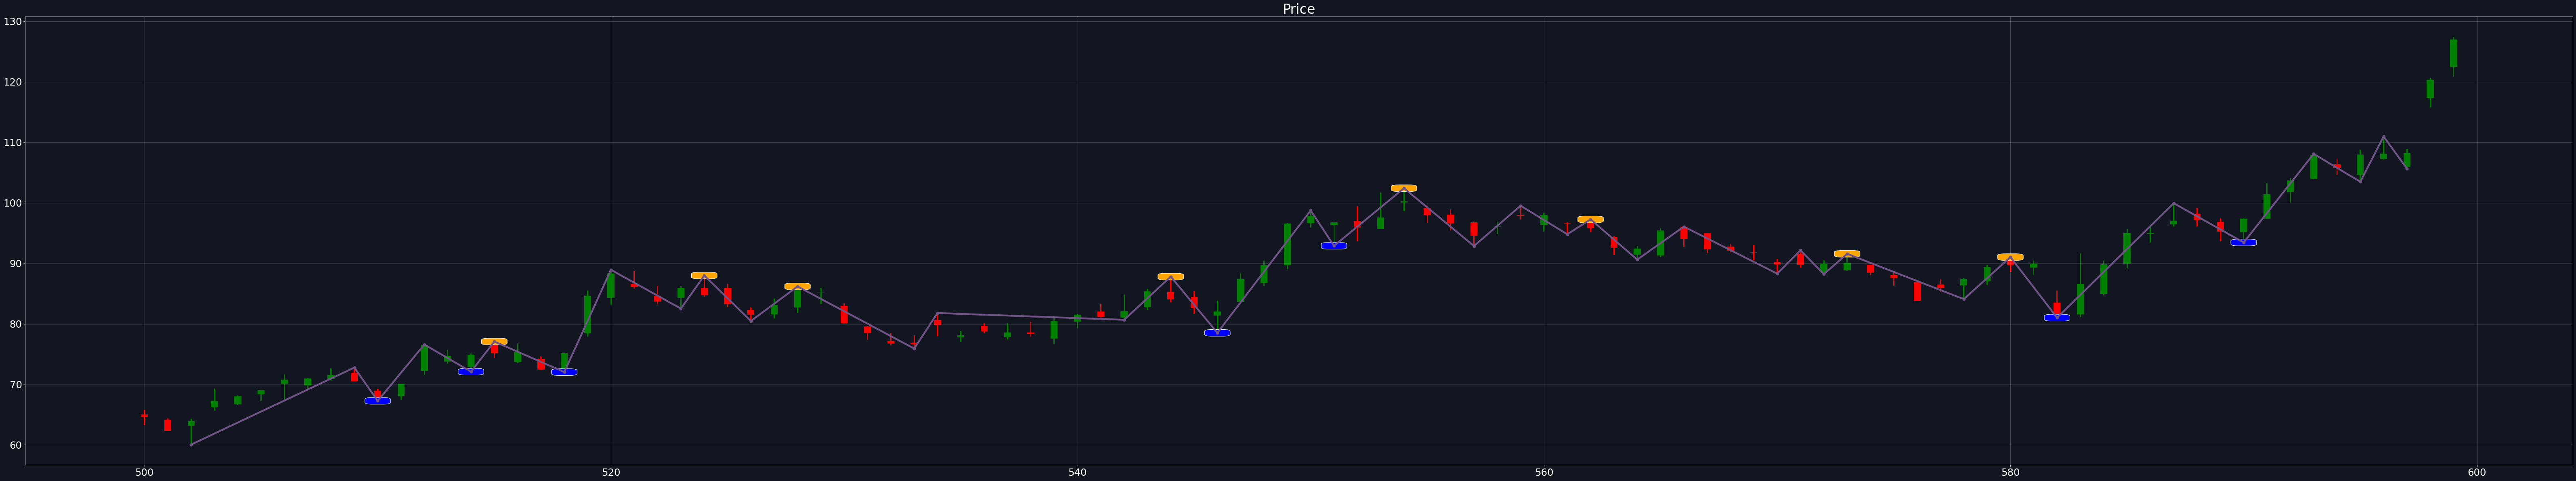

In [9]:
import pandas as pd
# from indicators.swing_points.swing_points_2 import SwingPointsIndicatorLogic
# from indicators.order_block.order_block import OrderBlockIndicatorLogic
# from indicators.bos_finder.bos_finder import BosFinderIndicatorLogic
import time

df = pd.read_csv("symbol_df.csv", index_col=0, header=[0, 1])
df.index = pd.DatetimeIndex(df.index)
df = df.reset_index(drop=True)
# getting one symbol for visualization
df = df.swaplevel(axis=1).sort_index(axis=1)["AMD"]
df = df.iloc[500:600]
# for reindexing the dataframe descending
#df = df.set_index(pd.Index(range(len(df)-1, -1, -1)))


data_calc = {"price": df}
meta_data = {}

swings = SwingPointsIndicatorLogic.logic(meta_data, data_calc, "1m")
data_calc["swings"] = swings

bos = BosFinderIndicatorLogic.logic(meta_data,data_calc,"1m")
data_calc["bos"] = bos

ob = OrderBlockIndicatorLogic.logic(meta_data,data_calc,"1m")
data_calc["order_block"] = ob

OrderBlockIndicatorLogic.visualize(meta_data, data_calc)



